Quantium Data Analytics Virtual Experience Program - Task 2

Exploration of Experimentation and Uplift Testing

Expanding on the analysis conducted in Task 1 to identify benchmark stores for assessing the impact of the trial store layouts on customer sales.

Background:

As a member of Quantium's retail analytics team, you have received a request from the Category Manager for Chips. The manager is interested in testing the effects of new trial layouts and seeks a data-driven recommendation on whether to implement these layouts across all stores.

Task Overview:

Julia, the Category Manager, has tasked the team with evaluating the performance of a store trial conducted in stores 77, 86, and 88. Utilize the QVI_data dataset provided below or the output from Task 1, focusing on the monthly sales experience of each store. Break down the analysis into:

Total sales revenue
Total number of customers
Average number of transactions per customer
Create a standardized measure to compare different control stores with each trial store. To streamline the analysis for each trial store, consider implementing a function. This function may utilize Pearson correlations or a metric like magnitude distance (e.g., 1 - (Observed distance – minimum distance) / (Maximum distance – minimum distance)).

Once control stores are identified, compare each trial and control pair during the trial period. The goal is to determine if total sales exhibit significant differences during the trial period. If differences are observed, investigate whether the driver of change is an increase in purchasing customers, purchases per customer, or other factors.

In [1]:
# Importing required libraries/modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime
import xlrd
%matplotlib inline

# Suppressing warnings.

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
qvi_data = pd.read_csv("QVI_data.csv")  # Reading the CSV file into a pandas.DataFrame.
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


In [3]:
# Displaying a concise summary of the pandas DataFrame.
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
# Checking for null values in the pandas DataFrame and displaying the sum of null values for each column.
qvi_data.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Let's initiate the process by matching a control store with each trial store, specifically stores 77, 86, and 88. The objective is to identify stores with similar characteristics to the trial stores before the entire sales recording period. This approach enables us to precisely determine whether a specific store has experienced a sales increase throughout the recorded duration.

To begin, we must aggregate key statistics about the stores for each recorded month across the entire sales duration. Our initial focus is on determining the total sales for each store in each month throughout the complete recording period.

In [6]:
# Create a new column "YEAR_MONTH" to store the year and month of the recorded duration
qvi_data["YEAR_MONTH"] = pd.to_datetime(qvi_data["DATE"]).dt.to_period("M")

# Display the updated pandas DataFrame
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,2018-12
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,2018-10
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,2018-10
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,2018-10


In [7]:
# Group the pandas DataFrame by "STORE_NBR" and "YEAR_MONTH" columns, and sum up the total sales for each group
total_sales = qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["TOT_SALES"].sum()

# Convert the pandas Series to a pandas DataFrame
total_sales = total_sales.to_frame()

# Display the updated pandas DataFrame
total_sales

TOT_SALES
STORE_NBR YEAR_MONTH           
1         2018-07         206.9
          2018-08         176.1
          2018-09         278.8
          2018-10         188.1
          2018-11         192.6
...                         ...
272       2019-02         395.5
          2019-03         442.3
          2019-04         445.1
          2019-05         314.6
          2019-06         312.1

[3169 rows x 1 columns]

Similarly, we can determine the count of unique customers for each month throughout the entire recorded period, corresponding to each store.

In [10]:
# Grouping the QVI data by store number and year-month, then counting the unique number of customers for each group
total_customers = qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["LYLTY_CARD_NBR"].nunique()

# Converting the result from a pandas Series to a pandas DataFrame
total_customers = total_customers.to_frame()

# Displaying the updated pandas DataFrame
total_customers

LYLTY_CARD_NBR
STORE_NBR YEAR_MONTH                
1         2018-07                 49
          2018-08                 42
          2018-09                 59
          2018-10                 44
          2018-11                 46
...                              ...
272       2019-02                 45
          2019-03                 50
          2019-04                 54
          2019-05                 34
          2019-06                 34

[3169 rows x 1 columns]

Moreover, we can determine the transactions per customer for each recorded month by dividing the count of unique transactions by the count of unique customers for each store.

In [11]:
# Grouping the DataFrame by STORE_NBR and YEAR_MONTH, and calculating the number of unique transactions per customer
transactions_per_customer = qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["TXN_ID"].nunique() / qvi_data.groupby(["STORE_NBR", "YEAR_MONTH"])["LYLTY_CARD_NBR"].nunique()

# Converting the resulting Series to a DataFrame
transactions_per_customer = transactions_per_customer.to_frame()

# Displaying the updated pandas DataFrame
transactions_per_customer

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.061224
          2018-08     1.023810
          2018-09     1.050847
          2018-10     1.022727
          2018-11     1.021739
...                        ...
272       2019-02     1.066667
          2019-03     1.060000
          2019-04     1.018519
          2019-05     1.176471
          2019-06     1.088235

[3169 rows x 1 columns]

In [12]:
# Creating a list of all the DataFrames
dataframe_list = [total_sales, total_customers, transactions_per_customer]

# Concatenating all the DataFrames into one
dataframe = pd.concat(dataframe_list, axis=1)

# Renaming the columns of the resulting DataFrame
dataframe.columns = ["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]

# Displaying the resulting DataFrame
dataframe

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3169 rows x 3 columns]

In [13]:
# Checking for any null values in the DataFrame
dataframe.isnull().sum()

TOT_SALES       0
TOT_CUST        0
TXN_PER_CUST    0
dtype: int64

As the dataset encompasses transaction details for numerous stores, it is possible that certain stores did not document sales throughout the entire duration.

In [14]:
# Pivot the pandas.DataFrame to obtain the count of transactions recorded for each store throughout the entire duration.
recorded_stores = pd.pivot_table(qvi_data, index="STORE_NBR", columns="YEAR_MONTH", values="TXN_ID", aggfunc="count")

# Displaying the updated DataFrame
recorded_stores

YEAR_MONTH,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [15]:
# Check for any null values in the pandas.DataFrame.
recorded_stores.isnull().sum()

YEAR_MONTH
2018-07    6
2018-08    9
2018-09    8
2018-10    7
2018-11    8
2018-12    9
2019-01    9
2019-02    8
2019-03    7
2019-04    7
2019-05    9
2019-06    8
Freq: M, dtype: int64

There are null values for certain months, indicating that some transactions are unrecorded for specific stores. To address this, we should identify and exclude these stores from the dataset, as they cannot serve as control stores.

In [16]:
# Initialize an empty list to store store numbers with missing data
stores_with_missing_data = []

# Iterate through store numbers in the index of the recorded_stores DataFrame
for store_index in recorded_stores.index:
    # Check if there are any null values for the transactions in each month for a store
    if recorded_stores.loc[store_index].isnull().any():
        # If there are null values, add the store number to the list
        stores_with_missing_data.append(store_index)

# Display the list of stores with missing data
stores_with_missing_data

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [18]:
# Drop rows corresponding to unrecorded stores from the dataframe
dataframe = dataframe.drop(stores_with_missing_data, axis=0)

# Displaying the updated DataFrame
dataframe

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3120 rows x 3 columns]

We can narrow down the dataset to the period before the trial, specifically before February 2022.

In [20]:
# Filter the dataset for the pre-trial duration (before February 2019)
pre_trial_data = dataframe[dataframe.index.get_level_values("YEAR_MONTH") < "2019-02"].reset_index()

# Displaying the updated DataFrame
pre_trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2018-07,206.9,49,1.061224
1,1,2018-08,176.1,42,1.023810
2,1,2018-09,278.8,59,1.050847
3,1,2018-10,188.1,44,1.022727
4,1,2018-11,192.6,46,1.021739
...,...,...,...,...,...
1815,272,2018-09,304.7,32,1.125000
1816,272,2018-10,430.6,44,1.136364
1817,272,2018-11,376.2,41,1.097561
1818,272,2018-12,403.9,47,1.000000


From the pre-trial dataset, we can now identify the control stores by excluding those with STORE_NBR 77, 88, and 89.

In [26]:
# Filter control stores from the pre-trial dataset, excluding STORE_NBR 77, 86, and 88
control_stores = pre_trial_data[
    (pre_trial_data.STORE_NBR != 77) & 
    (pre_trial_data.STORE_NBR != 86) & 
    (pre_trial_data.STORE_NBR != 88)
][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]]

# Group by STORE_NBR and sum the total sales, total customers, and transactions per customer for control stores
control_stores = control_stores.groupby(pre_trial_data.STORE_NBR).sum()

# Display the control stores dataset
control_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
1,1386.90,317,7.327967
2,1128.50,272,7.359700
3,7526.15,744,8.209829
4,9127.00,849,8.535253
5,5739.70,651,8.791906
...,...,...,...
268,1549.05,304,7.373037
269,6664.50,746,8.921035
270,6697.95,734,9.147187


Similarly, we can filter out the trial stores from the dataset.

In [27]:
# Extracting data for trial stores (stores 77, 86, and 88) from the pre-trial dataset
trial_stores = pre_trial_data[(pre_trial_data.STORE_NBR == 77) | (pre_trial_data.STORE_NBR == 86) | (pre_trial_data.STORE_NBR == 88)][["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()

# Display the trial_stores dataset
trial_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
77,1699.00,299,7.405289
86,6119.85,697,8.798544
88,9383.60,880,8.523817


After filtering both the control stores and the trial stores, we can calculate the Pearson correlation coefficient of the attributes between them. This will help us identify the control stores for each of the trial stores.

For STORE_NBR 77:

In [28]:
# Calculate the correlation between trial store 77 and control stores
correlation_scores = control_stores.corrwith(trial_stores.loc[77], method="pearson", axis=1)

# Get the top five stores with the highest correlation to trial store 77
top_correlated_stores = control_stores.loc[correlation_scores.nlargest(5).index]

# Calculate the difference between trial store 77 and the top correlated stores
difference = (trial_stores.loc[77] - top_correlated_stores).sort_values(by="TOT_SALES", ascending=False)

# Calculate the difference in total sales and sort the DataFrame
difference["DIFFERENCE"] = difference["TOT_SALES"] - difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
139,1493.2,257.0,0.405289,609.34
135,1486.9,256.0,0.012432,603.04
161,1459.0,252.0,0.405289,575.14
233,39.2,1.0,0.115969,-844.66
46,-59.0,-3.0,0.094215,-942.86


For STORE_NBR 77, it is observed that STORE_NBR 46 is the most appropriate choice as the control store.

• STORE_NBR 86:

In [29]:
# Getting the top five stores with the highest correlation with the trial store (STORE_NBR 86)
difference = control_stores.loc[control_stores.corrwith(trial_stores.loc[86], axis=1).nlargest(5).index]

# Calculating the difference between the trial store and the top five stores with the highest correlation
difference = (trial_stores.loc[86] - difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"] = difference["TOT_SALES"] - difference["TOT_SALES"].mean()
difference.sort_values(by="DIFFERENCE", ascending=False)  # Sorting the pandas.DataFrame by the DIFFERENCE column.

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
258,5934.85,670.0,1.798544,4066.46
215,3411.85,386.0,1.486773,1543.46
225,29.25,3.0,0.023669,-1839.14
196,-6.45,1.0,0.040716,-1874.84
57,-27.55,-2.0,0.031815,-1895.94


For STORE_NBR 86, it is evident that STORE_NBR 57 would serve as the most appropriate control store.

• STORE_NBR 88:

In [30]:
# Selecting the top five stores with the highest correlation with the trial store (STORE_NBR 88)
difference = control_stores.loc[control_stores.corrwith(trial_stores.loc[88], axis=1).nlargest(5).index]

# Calculating the difference between the trial store and the top five stores with the highest correlation
difference = (trial_stores.loc[88] - difference).sort_values(by="TOT_SALES", ascending=False)
difference["DIFFERENCE"] = difference["TOT_SALES"] - difference["TOT_SALES"].mean()

# Sorting the resulting DataFrame by the DIFFERENCE column
difference.sort_values(by="DIFFERENCE", ascending=False)

,TOT_SALES,TOT_CUST,TXN_PER_CUST,DIFFERENCE
STORE_NBR,,,,
60,1697.1,154.0,0.052504,783.5
75,1420.1,129.0,0.078986,506.5
72,865.1,79.0,0.085871,-48.5
203,439.9,38.0,0.135139,-473.7
165,145.8,18.0,0.093389,-767.8


For STORE_NBR 88, STORE_NBR 165 emerges as the most suitable control store. Now, let's compare various control stores to each of the trial stores during the pre-trial duration to identify any significant differences in the statistics.

In [31]:
# Extracting the pandas.DataFrames for each of the trial stores.
trial_stores_one = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([77])].reset_index()
trial_stores_two = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([86])].reset_index()
trial_stores_three = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([88])].reset_index()

# Extracting the pandas.DataFrames for each of the control stores.
control_stores_one = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([46])].reset_index()
control_stores_two = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([57])].reset_index()
control_stores_three = pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([165])].reset_index()

# Concatenating all the pandas.DataFrames into one.
stores = pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)
stores

,index,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,504,77,2018-07,296.80,51,1.078431
1,505,77,2018-08,255.50,47,1.021277
2,506,77,2018-09,225.20,42,1.047619
3,507,77,2018-10,204.50,37,1.027027
4,508,77,2018-11,245.30,41,1.073171
5,509,77,2018-12,267.30,46,1.043478
6,510,77,2019-01,204.40,35,1.114286
0,560,86,2018-07,892.20,99,1.272727
1,561,86,2018-08,764.05,94,1.170213
2,562,86,2018-09,914.60,103,1.242718


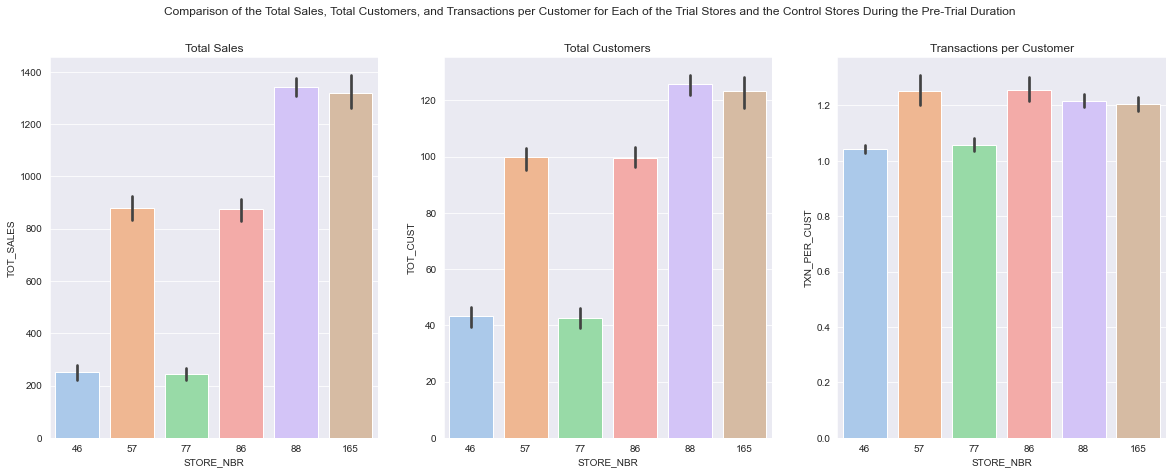

In [32]:
# Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.
sns.set_style("darkgrid")
figure, axis = plt.subplots(1, 3, figsize=(20, 7))

sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")

sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")

sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")

figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each of the Trial Stores and the Control Stores During the Pre-Trial Duration")
plt.show()

Although the performance of the other trial stores matched that of their respective control stores, STORE_NBR 88 demonstrated a slight outperformance across all attributes compared to its control store. Notably, there is a substantial difference in total sales between STORE_NBR 86 and 88, while STORE_NBR 77 exhibits considerably lower sales.

Similarly, we can extend our analysis to compare various control stores with each trial store during the trial duration. This will help us determine if there are significant differences in total sales during the trial period.

In [34]:
# Extracting the pandas.DataFrame for the trial duration.
trial_data = dataframe.loc[dataframe.index.get_level_values("YEAR_MONTH") >= "2019-02"]
trial_data = trial_data.reset_index()
trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2019-02,225.4,52,1.057692
1,1,2019-03,192.9,45,1.088889
2,1,2019-04,192.9,42,1.023810
3,1,2019-05,221.4,46,1.108696
4,1,2019-06,174.1,42,1.000000
...,...,...,...,...,...
1295,272,2019-02,395.5,45,1.066667
1296,272,2019-03,442.3,50,1.060000
1297,272,2019-04,445.1,54,1.018519
1298,272,2019-05,314.6,34,1.176471


In [35]:
# Extracting the pandas.DataFrames for each of the trial stores.
trial_stores_one = trial_data.loc[trial_data.STORE_NBR.isin([77])].reset_index()
trial_stores_two = trial_data.loc[trial_data.STORE_NBR.isin([86])].reset_index()
trial_stores_three = trial_data.loc[trial_data.STORE_NBR.isin([88])].reset_index()

# Extracting the pandas.DataFrames for each of the control stores.
control_stores_one = trial_data.loc[trial_data.STORE_NBR.isin([46])].reset_index()
control_stores_two = trial_data.loc[trial_data.STORE_NBR.isin([57])].reset_index()
control_stores_three = trial_data.loc[trial_data.STORE_NBR.isin([165])].reset_index()

# Concatenating all the pandas.DataFrames into one.
stores = pd.concat([trial_stores_one, trial_stores_two, trial_stores_three, control_stores_one, control_stores_two, control_stores_three], axis=0)
stores

,index,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,360,77,2019-02,235.00,45,1.000000
1,361,77,2019-03,278.50,50,1.100000
2,362,77,2019-04,263.50,47,1.021277
3,363,77,2019-05,299.30,55,1.018182
4,364,77,2019-06,264.70,41,1.024390
0,400,86,2019-02,913.20,107,1.289720
1,401,86,2019-03,1026.80,115,1.217391
2,402,86,2019-04,848.20,105,1.200000
3,403,86,2019-05,889.30,104,1.230769
4,404,86,2019-06,838.00,98,1.204082


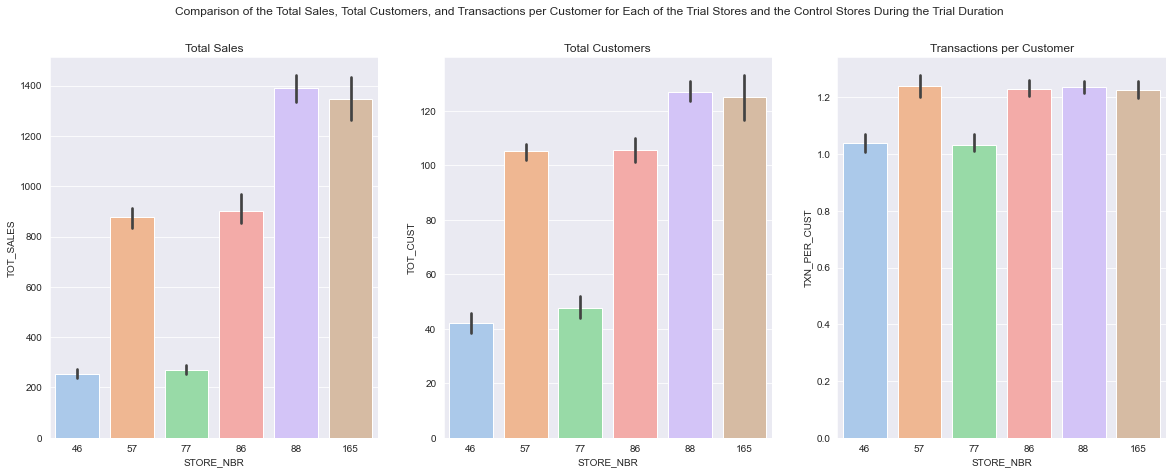

In [36]:
# Plotting the bar graphs for the total sales, total customers, and transactions per customer for each of the trial stores and the control stores.
sns.set_style("darkgrid")
figure, axis = plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales")
sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers")
sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer")
figure.suptitle("Comparison of the Total Sales, Total Customers, and Transactions per Customer for Each of the Trial Stores and the Control Stores During the Trial Duration")
plt.show()

Upon further analysis, STORE_NBR 88 continues to exhibit a slight edge over its control store, STORE_NBR 165, making it the most successful trial implementation among all the trial stores. The key factor contributing to this success appears to be an increase in the number of purchasing customers, rather than the number of purchases per customer. Notably, as the total number of customers rises, there is a nearly identical increase in total sales. Additionally, transactions per customer remain reasonably high for all trial stores, irrespective of total sales.

Conclusion:
While the performance of other trial stores aligns with their respective control stores, STORE_NBR 88 consistently outperforms its control store, STORE_NBR 165, across all measured attributes. STORE_NBR 86 and 88 demonstrate a significant disparity in total sales, unlike STORE_NBR 77, which may be attributed to variations in the trial implementation.

Considering the substantial variance in total sales among the trial stores, STORE_NBR 88 emerges as the most successful trial implementation. The primary catalyst for the surge in total sales appears to be the influx of purchasing customers, indicating that a higher customer count correlates with increased sales.